<a href="https://colab.research.google.com/github/fengp/DS_Python/blob/master/Amazon_Product_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load the data**

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193643 sha256=9e61451f3f845f9efd14f3f58ed84485a3762230288373ca570aaad48874a650
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [5]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_csv('/content/drive/MyDrive/AmazonRating/ratings_Electronics.csv', header = None) 

In [7]:
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [8]:
df = df.drop ('timestamp',axis=1)

In [9]:
df.shape

(7824482, 3)

In [10]:
df_copy = df.copy(deep=True)

In [11]:
# Get the column containing the users
users=df.user_id

In [12]:
ratings_count = dict()
for user in users:
  if user in ratings_count:
    ratings_count[user] += 1
  else:
    ratings_count[user]=1

In [13]:
ratings_count

{'AKM1MP6P0OYPR': 2,
 'A2CX7LUOHB2NDG': 4,
 'A2NWSAGRHCP8N5': 1,
 'A2WNBOD3WNDNKT': 1,
 'A1GI0U4ZRJA8WN': 1,
 'A1QGNMC6O1VW39': 2,
 'A3J3BRHTDRFJ2G': 19,
 'A2TY0BTJOTENPG': 4,
 'A34ATBPOK6HCHY': 3,
 'A89DO69P0XZ27': 1,
 'AZYNQZ94U6VDB': 5,
 'A1DA3W4GTFXP6O': 1,
 'A29LPQQDG7LD5J': 1,
 'AO94DHGC771SJ': 9,
 'AMO214LNFCEI4': 9,
 'A28B1G1MSJ6OO1': 2,
 'A3N7T0DY83Y4IG': 14,
 'A1H8PY3QHMQQA0': 27,
 'A2CPBQ5W4OGBX': 2,
 'A265MKAR2WEH3Y': 2,
 'A37K02NKUIT68K': 3,
 'A2AW1SSVUIYV9Y': 1,
 'A2AEHUKOV014BP': 1,
 'AMLFNXUIEMN4T': 1,
 'A2O8FIJR9EBU56': 1,
 'A3IQGFB959IR4P': 1,
 'AYTBGUX49LF3W': 1,
 'A24QFSUU00IZ05': 1,
 'A1NG5X8VYZWX0Q': 1,
 'A1E4WG8HRWWK4R': 3,
 'A2AOEW5UGXFOOQ': 1,
 'A2XSWV6AQI90BR': 2,
 'AR84FMFYCQCWF': 1,
 'A19TBA1WARJS55': 1,
 'A3C5SMBSKKWNPT': 1,
 'A24EV6RXELQZ63': 6,
 'A3T6ZQONABIJSG': 2,
 'A132P6YSJSI5G2': 1,
 'A1NQPG5IJ43HJI': 6,
 'A2WOJCFAWI8VS8': 2,
 'A22FB2WSZSXSHH': 1,
 'AZQZ3STMCBG5H': 1,
 'A2EGPA22UHMQXL': 1,
 'AC57CU3TF6ZMJ': 1,
 'A2YX0Z6RHA8Y2H': 1,
 'A38T51B7J6QVD9':

In [14]:
len(ratings_count)

4201696

In [15]:
#users to have at least 50 ratings
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
  if num_ratings < RATINGS_CUTOFF:
    remove_users.append(user)

df = df.loc [~ df.user_id.isin(remove_users)]

In [16]:
df.shape

(125871, 3)

In [17]:
# Get the column containing the products
prods = df.prod_id

ratings_count = dict()

for prod in prods: 
  if prod in ratings_count:
    ratings_count[prod] += 1
  else: 
    ratings_count [prod] = 1

In [18]:
# items to have at least 5 ratings
RATINGS_CUTOFF = 5

remove_users =[] 

for user, num_ratings in ratings_count.items():
  if num_ratings < RATINGS_CUTOFF:
    remove_users.append(user)

df_final = df.loc[~df.prod_id.isin(remove_users)]

In [19]:
len(remove_users)

42501

In [20]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [21]:
df_final.shape

(65290, 3)

#**Exploratory Data Analysis**


**Shape of the Data**

In [22]:
rows, columns = df_final.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  65290
No of columns:  3


Observations: The data set has 2,281,128 rows and 3 columns

**Data Types**

In [23]:
type(df_final)

pandas.core.frame.DataFrame

Observations: the data type of the data set is a data frame

**Check for missing values**

In [24]:
##Q1: Check for missing value in the data and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [25]:
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

Observations: there is no missing values in the data

**Summary of Statistics**

In [26]:
##Q: Summary statistics of 'rating" variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Checking the rating distribution**

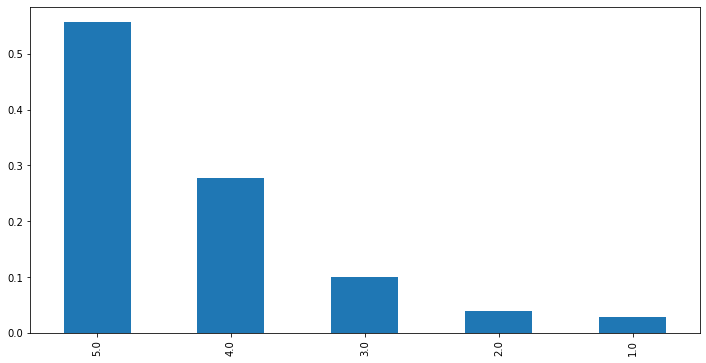

In [27]:
# Create the bar plot and provide observations
plt.figure (figsize = (12,6))
df_final['rating'].value_counts(1).plot(kind= 'bar')
plt.show()

Observations: The majority (more than 50%) ratings are scored at 5. 

Check the number of unique users and items in the dataset

In [28]:
## Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


Observations: there are 1,540 unique users and 5,689 products in the data set.

**Users with the most number of ratings**

In [29]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby ('user_id').size().sort_values (ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

### **Data Preparation**

Question: Check the number of unique Users and Products in the final data and provide observations.

In [30]:
print ('The number of observations in the final data =', len(df_final))
print ('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print ('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 65290
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  5689


Observations: 
The number of observations in the final data = 65290
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  5689

### **Model1: Rank Based Recommendation System**

In [31]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [32]:
# Calculate the average rating for each product 
average_rating = df_final.groupby('prod_id').mean()['rating']

# Calculate the count of ratings for each product
count_rating = df.groupby('prod_id').count()['rating']

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending = False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [33]:
# Define a function to get the top number of products based on the highest average rating and minimum interactions

def top_n_products (data, n, min_interaction):
  # Finding products with minimum number of interations
  recommendations = data[data['rating_count']> min_interaction]
  # Sorting values with respect to average rating
  recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
  return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**


In [34]:
top_n_products(final_rating,5,50)

Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [35]:
top_n_products(final_rating,5,100)

Index(['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC'], dtype='object', name='prod_id')

### **Model2:Collaborative Filtering Recommendation System**

**Building a baseline user-user similarity based recommendation system**

*   Below, we are building similarity-based recommendation ssytems using cosine similarity and using KNN to find similar users which are the nearest neighbor to the given user.
*   We will be using a new library, called surprise, to build the remaining models. Let's first import the necessary classes adn functions from this library.

In [36]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering


*   Build a function that takes the recommendation model as input and gives the precision@k, recall@k, and F1-score@k for that model.
*   To compute precision and recall, top k predictions are taken under consideration for each user.
*   We will use the precision and recall to compute the F1-score.

In [37]:
def precision_recall_at_k(model, k=10, threshold = 3.5):
  user_est_true = defaultdict(list)
  predictions = model.test(testset)
  for uid,_,true_r, est, _ in predictions:
    user_est_true[uid].append((est,true_r))

  precisions = dict()
  recalls = dict()
  for uid, user_ratings in user_est_true.items():
    # Sort user ratings by estimated value
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    # Number of relevant items
    n_rel = sum((true_r>=threshold) for (_, true_r)in user_ratings)
    # Number of recommended items in top k
    n_rec_k = sum ((est >=threshold) for (est, _)in user_ratings[:k])
    # Number of relevant and recommended items in top k
    n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))for (est, true_r)in user_ratings[:k])
    
    # Precision@K: Production of recommended items that are relevant
    # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0
    
    precisions[uid]= n_rel_and_rec_k/n_rec_k if n_rec_k != 0 else 0
    # Recall@K: Proportion of relevant items that are recommended
    # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

    recalls[uid] = n_rel_and_rec_k/n_rel if n_rel != 0 else 0
    #mean of all the predicted precisions:
    precision = round((sum(prec for prec in precisions.values())/len(precisions)),3)
    #Mean of all the predicted recalls are calculated. 
    recall = round ((sum(rec for rec in recalls.values())/len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision:', precision)
    print ('Recall:', recall)
    print ('F_1 score', round((2*precision*recall)/(precision+recall),3))


In [38]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [39]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

**Question: Build the user-user similarity-based recommendation system**

Initialize the KNNBasic model using sim_options 
provided, Verbose=False, and setting random_state=1 

Fit the model on the training data 

Use the precision_recall_at_k function to calculate the metrics on the test data

Provide your observations on the output 

In [40]:
# Declaring the similarity options
sim_options = {'name':'cosine', 'user_based':True}

# Initialize the KNNBasic model using sim_options provided, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose= False, random_state =1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)


Streaming output truncated to the last 5000 lines.
RMSE: 1.0012
Precision: 0.87
Recall: 0.785
F_1 score 0.825
RMSE: 1.0012
Precision: 0.87
Recall: 0.785
F_1 score 0.825
RMSE: 1.0012
Precision: 0.87
Recall: 0.786
F_1 score 0.826
RMSE: 1.0012
Precision: 0.87
Recall: 0.786
F_1 score 0.826
RMSE: 1.0012
Precision: 0.87
Recall: 0.787
F_1 score 0.826
RMSE: 1.0012
Precision: 0.87
Recall: 0.788
F_1 score 0.827
RMSE: 1.0012
Precision: 0.87
Recall: 0.788
F_1 score 0.827
RMSE: 1.0012
Precision: 0.87
Recall: 0.789
F_1 score 0.828
RMSE: 1.0012
Precision: 0.87
Recall: 0.789
F_1 score 0.828
RMSE: 1.0012
Precision: 0.87
Recall: 0.789
F_1 score 0.828
RMSE: 1.0012
Precision: 0.869
Recall: 0.789
F_1 score 0.827
RMSE: 1.0012
Precision: 0.87
Recall: 0.79
F_1 score 0.828
RMSE: 1.0012
Precision: 0.87
Recall: 0.79
F_1 score 0.828
RMSE: 1.0012
Precision: 0.87
Recall: 0.79
F_1 score 0.828
RMSE: 1.0012
Precision: 0.87
Recall: 0.79
F_1 score 0.828
RMSE: 1.0012
Precision: 0.87
Recall: 0.79
F_1 score 0.828
RMSE: 1.0

In [41]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid=4, iid=10, r_ui=4, est=4.292024046561495, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

Observations: The above output shows that the actual rating is not so far from the predicted rating for this user-item pair by this user-user-similarity-based baseline model

Let's now predict rating for a user with userId=A3LDPF5FMB782Z and productId=1400501466 as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5 which is denoted by the parameter r_ui.

In [42]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

The above output shows that the actual rating for this user-item pair is 5, and the predicted rating is 3.40 by this user-user-similarity-based baseline model.

Below is the list of users who have not seen the product with product id "1400501466".

In [43]:
df_final[df_final.prod_id == "1400501466"].user_id.unique()

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY',
       'AW3LX47IHPFRL', 'A1E3OB6QMBKRYZ', 'A19N3S7CBSU6O7'], dtype=object)

It can be observed from the above list that user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466" as this user id is not a part of the above list.

Below we are predicting rating for the same userId=A34BZM6S9L7QI4 but for a product which this user has not seen yet i.e. prod_id=1400501466

In [44]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

The predicted rating for this user is around 4.
3 based on this user-user similarity-based baseline model.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the KNNBasic algorithms. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:


*   k (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
*   min_k (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1

*   sim_options (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
*   cosine
*   msd (default)
*   Pearson
*   Pearson baseline

In [45]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9719198067389213
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above.

Now, let's build the final model by using tuned values of the hyperparameters, which we received by using grid search cross-validation.

In [46]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

Streaming output truncated to the last 5000 lines.
RMSE: 0.9526
Precision: 0.852
Recall: 0.799
F_1 score 0.825
RMSE: 0.9526
Precision: 0.852
Recall: 0.799
F_1 score 0.825
RMSE: 0.9526
Precision: 0.852
Recall: 0.8
F_1 score 0.825
RMSE: 0.9526
Precision: 0.852
Recall: 0.801
F_1 score 0.826
RMSE: 0.9526
Precision: 0.852
Recall: 0.802
F_1 score 0.826
RMSE: 0.9526
Precision: 0.853
Recall: 0.802
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.803
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.804
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.804
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.803
F_1 score 0.827
RMSE: 0.9526
Precision: 0.851
Recall: 0.803
F_1 score 0.826
RMSE: 0.9526
Precision: 0.851
Recall: 0.804
F_1 score 0.827
RMSE: 0.9526
Precision: 0.851
Recall: 0.803
F_1 score 0.826
RMSE: 0.9526
Precision: 0.851
Recall: 0.803
F_1 score 0.826
RMSE: 0.9526
Precision: 0.852
Recall: 0.804
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.804
F_1 sco

We can observe that after tuning hyperparameters, F_1 score of the tuned model is 0.827, which is slightly better than the baseline model. Along with this, the RMSE of the model has gone down as compared to the model before hyperparameter tuning. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

Let's now predict the rating for a user with userId = "A3LDPF5FMB782Z", and prod_id = 1400501466 with the optimized model as shown below.

Question:

*   Predict rating for the user with userId="A3LDPF5FMB782Z", and prod_id= 1400501466 using the optimized model (1 Mark)
*   Predict rating for the same userId="A34BZM6S9L7QI4" but for a product with which this user has not interacted before, i.e., prod_id = 1400501466, by using the optimized model (1 Mark)
*   Compare the output with the output from the baseline model (2 Marks)

In [47]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [48]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [49]:
df_final[df_final.prod_id == "1400501466"].user_id.unique()

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY',
       'AW3LX47IHPFRL', 'A1E3OB6QMBKRYZ', 'A19N3S7CBSU6O7'], dtype=object)

It can be observed from the above list that user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466" as this user id is not a part of the above list.

Below we are predicting rating for the same userId=A34BZM6S9L7QI4 but for a product which this user has not seen yet i.e. prod_id=1400501466

In [50]:
# Predicting rating for a sample user with a non interacted product
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observation: The predicted rating for this user is around 4.3 based on this user-user similarity-based optimized model.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the KNNBasic algorithms. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:


*   k (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
*   min_k (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
*   sim_options (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
*   cosine
*   msd (default)
*   Pearson
*   Pearson baseline

In [51]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9724323563075262
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above.

Now, let's build the final model by using tuned values of the hyperparameters, which we received by using grid search cross-validation.

In [52]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

Streaming output truncated to the last 5000 lines.
RMSE: 0.9526
Precision: 0.852
Recall: 0.799
F_1 score 0.825
RMSE: 0.9526
Precision: 0.852
Recall: 0.799
F_1 score 0.825
RMSE: 0.9526
Precision: 0.852
Recall: 0.8
F_1 score 0.825
RMSE: 0.9526
Precision: 0.852
Recall: 0.801
F_1 score 0.826
RMSE: 0.9526
Precision: 0.852
Recall: 0.802
F_1 score 0.826
RMSE: 0.9526
Precision: 0.853
Recall: 0.802
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.803
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.804
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.804
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.803
F_1 score 0.827
RMSE: 0.9526
Precision: 0.851
Recall: 0.803
F_1 score 0.826
RMSE: 0.9526
Precision: 0.851
Recall: 0.804
F_1 score 0.827
RMSE: 0.9526
Precision: 0.851
Recall: 0.803
F_1 score 0.826
RMSE: 0.9526
Precision: 0.851
Recall: 0.803
F_1 score 0.826
RMSE: 0.9526
Precision: 0.852
Recall: 0.804
F_1 score 0.827
RMSE: 0.9526
Precision: 0.852
Recall: 0.804
F_1 sco

We can observe that after tuning hyperparameters, F_1 score of the tuned model is 0.87, which is slightly better than the baseline model. Along with this, the RMSE of the model has gone down as compared to the model before hyperparameter tuning. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

Let's now predict the rating for a user with userId = "A3LDPF5FMB782Z", and prod_id = 1400501466 with the optimized model as shown below.

Question:
*   Predict rating for the user with userId="A3LDPF5FMB782Z", and prod_id= 1400501466 using the optimized model (1 Mark)
*   Predict rating for the same userId="A34BZM6S9L7QI4" but for a product with which this user has not interacted before, i.e., prod_id = 1400501466, by using the optimized model ((1 Mark)
*   Compare the output with the output from the baseline model (2 Marks)

In [53]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [54]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

The predicted rating for this user is around 4.3 based on this user-user similarity-based optimized model

### **Identifying similar Users to a given User (nearest neighbors)**

We can also find out similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the msd distance metric.

In [55]:
# Here, 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:
*  data: A rating dataset
*  user_id: A user id against which we want the recommendations
*  top_n: The number of products we want to recommend
*  algo: the algorithm we want to use for predicting the ratings
*  The output of the function is a set of top_n items recommended for the given user_id based on the given algorithm

In [74]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system

In [75]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [76]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Correcting the Ratings and Ranking the above products**

While comparing the ratings of two products, it is not only the ratings that describe the likelihood of the user to that product. Along with the rating, **the number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the** "corrected_ratings"** for each product. Commonly higher the "rating_count" of a product more it is liked by users. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product.**

In [77]:
def ranking_products(recommendations, final_rating):
  # Sort the products based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

  # Merge with the recommended products to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings']), on = 'prod_id', how = 'inner')

  # Rank the products based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # Sort the products based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)
  
  return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity 1/np.sqrt(n) instead of subtracting it to get more optimistic predictions.** But here we are **subtracting this quantity**, as there are some products with ratings 5 and we **can't have a rating more than 5 for a product.**

In [78]:
# Applying the ranking products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


### **Item-Item Similarity-based collaborative filtering recommendation systems**

Above we have seen similarity-based collaborative filtering where similarity is calculated between users. Now let us look into similarity-based collaborative filtering where similarity is seen between items.

In [59]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

Streaming output truncated to the last 5000 lines.
RMSE: 0.9950
Precision: 0.833
Recall: 0.756
F_1 score 0.793
RMSE: 0.9950
Precision: 0.833
Recall: 0.757
F_1 score 0.793
RMSE: 0.9950
Precision: 0.833
Recall: 0.757
F_1 score 0.793
RMSE: 0.9950
Precision: 0.834
Recall: 0.758
F_1 score 0.794
RMSE: 0.9950
Precision: 0.834
Recall: 0.756
F_1 score 0.793
RMSE: 0.9950
Precision: 0.835
Recall: 0.755
F_1 score 0.793
RMSE: 0.9950
Precision: 0.834
Recall: 0.756
F_1 score 0.793
RMSE: 0.9950
Precision: 0.835
Recall: 0.757
F_1 score 0.794
RMSE: 0.9950
Precision: 0.835
Recall: 0.757
F_1 score 0.794
RMSE: 0.9950
Precision: 0.835
Recall: 0.757
F_1 score 0.794
RMSE: 0.9950
Precision: 0.834
Recall: 0.757
F_1 score 0.794
RMSE: 0.9950
Precision: 0.834
Recall: 0.758
F_1 score 0.794
RMSE: 0.9950
Precision: 0.835
Recall: 0.758
F_1 score 0.795
RMSE: 0.9950
Precision: 0.835
Recall: 0.758
F_1 score 0.795
RMSE: 0.9950
Precision: 0.835
Recall: 0.759
F_1 score 0.795
RMSE: 0.9950
Precision: 0.835
Recall: 0.759
F_1 s

The baseline model is giving a good F_1 score of ~ 84%. We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

Let's now predict a rating for a user with userId = A3LDPF5FMB782Z and prod_Id = 1400501466 as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [60]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

The above output shows that the actual rating for this user-item pair is 5 and the predicted rating is 4.27 by this item-item-similarity-based baseline model.

Below we are predicting rating for the same userId = A34BZM6S9L7QI4 but for a product with which this user has not interacted yet, i.e., prod_id = 1400501466.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

As we can see the **predicted rating for this user-item pair is good (around 4.3) based on this item-item similarity-based baseline model.**

**Improving similarity-based recommendation system by tuning its hyperparameters**

Below we will be **tuning hyperparameters for the KNNBasic algorithms.**

### **Question: Hyperparameter tuning the item-item similarity-based model.**

*   Use the following values for the param_grid and tune the model. (3 Marks)
    *   'k': [10, 20, 30]
    *   'min_k': [3, 6, 9]
    *   'sim_options': {'name': ['msd', 'cosine']
    *   'user_based': [False]
*   Use GridSearchCV() to tune the model using the 'rmse' measure (2 Marks)
*   Print the best score and best parameters (1 Mark)

In [63]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'K': [10,20,30], 'min_k':[3,6,9],'sim_options':{'name': ['msd','cosine'], 'user_based':[False]}}

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv=3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.975235746100827
{'K': 10, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the optimal values for each of those hyperparameters as shown above.

Now let's build the **final model **by using t**uned values of the hyperparameters** which we received by using grid search cross-validation.

**Question: Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [62]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k=30 , min_k=6 , random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_item_item_optimized.fit (trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

Streaming output truncated to the last 5000 lines.
RMSE: 0.9576
Precision: 0.839
Recall: 0.788
F_1 score 0.813
RMSE: 0.9576
Precision: 0.839
Recall: 0.789
F_1 score 0.813
RMSE: 0.9576
Precision: 0.839
Recall: 0.789
F_1 score 0.813
RMSE: 0.9576
Precision: 0.839
Recall: 0.79
F_1 score 0.814
RMSE: 0.9576
Precision: 0.839
Recall: 0.791
F_1 score 0.814
RMSE: 0.9576
Precision: 0.84
Recall: 0.791
F_1 score 0.815
RMSE: 0.9576
Precision: 0.839
Recall: 0.791
F_1 score 0.814
RMSE: 0.9576
Precision: 0.839
Recall: 0.792
F_1 score 0.815
RMSE: 0.9576
Precision: 0.84
Recall: 0.792
F_1 score 0.815
RMSE: 0.9576
Precision: 0.84
Recall: 0.792
F_1 score 0.815
RMSE: 0.9576
Precision: 0.839
Recall: 0.793
F_1 score 0.815
RMSE: 0.9576
Precision: 0.839
Recall: 0.793
F_1 score 0.815
RMSE: 0.9576
Precision: 0.84
Recall: 0.793
F_1 score 0.816
RMSE: 0.9576
Precision: 0.84
Recall: 0.793
F_1 score 0.816
RMSE: 0.9576
Precision: 0.84
Recall: 0.794
F_1 score 0.816
RMSE: 0.9576
Precision: 0.84
Recall: 0.793
F_1 score 0.8

observations: we can observe that after hyper parameters, F_1 score (~86%) of the model is better than the baseline model. Along with this, the RMSE of the model has gone down in comparison to the model with default hyperparameters. Hence, we can say that the model performance has improved after hyperparameter tuning

Let's us now predict rating for an user with userId = A3LDPF5FMB782Z and for prod_id = 1400501466 with the optimized model as shown below:

In [80]:
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

Below we are predicting rating for the same userId = A34BZM6S9L7QI4 but for a product with which this user has not interacted before, i.e., prod_id == 1400501466, by using the optimized model as shown below:

In [81]:
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

*   For an unknown product the model is prediting a rating of 4.29. 

Identifying similar items to a given item (nearest neighbors)

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the **msd** distance metric.

In [82]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[29, 53, 67, 106, 151]

Predicted top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.

In [83]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [84]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [85]:
# Applying the ranking products function and sorting it based on the corrected ratings 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms.**

## **Model 3: Matrix Factorization**

Model-based Collaborative Filtering is a personalized recommendation system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use latent features to find recommendations for each user.

**Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we miss values in the **user-item matrix**.

**Question: Build the matrix factorization recommendation system (using random_state = 1) and provide your observations on the performance of the model.**

In [86]:
# Using SVD matrix factorization
svd = SVD (random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


Streaming output truncated to the last 5000 lines.
RMSE: 0.8882
Precision: 0.867
Recall: 0.802
F_1 score 0.833
RMSE: 0.8882
Precision: 0.867
Recall: 0.803
F_1 score 0.834
RMSE: 0.8882
Precision: 0.867
Recall: 0.804
F_1 score 0.834
RMSE: 0.8882
Precision: 0.867
Recall: 0.804
F_1 score 0.834
RMSE: 0.8882
Precision: 0.867
Recall: 0.805
F_1 score 0.835
RMSE: 0.8882
Precision: 0.867
Recall: 0.806
F_1 score 0.835
RMSE: 0.8882
Precision: 0.867
Recall: 0.806
F_1 score 0.835
RMSE: 0.8882
Precision: 0.867
Recall: 0.807
F_1 score 0.836
RMSE: 0.8882
Precision: 0.867
Recall: 0.807
F_1 score 0.836
RMSE: 0.8882
Precision: 0.867
Recall: 0.806
F_1 score 0.835
RMSE: 0.8882
Precision: 0.866
Recall: 0.807
F_1 score 0.835
RMSE: 0.8882
Precision: 0.866
Recall: 0.808
F_1 score 0.836
RMSE: 0.8882
Precision: 0.866
Recall: 0.807
F_1 score 0.835
RMSE: 0.8882
Precision: 0.866
Recall: 0.807
F_1 score 0.835
RMSE: 0.8882
Precision: 0.867
Recall: 0.808
F_1 score 0.836
RMSE: 0.8882
Precision: 0.867
Recall: 0.808
F_1 s

Observations: 
RMSE: 0.8882
Precision: 0.853
Recall: 0.88
F_1 score 0.866

*   Let's now predict the rating for a user with  userId = "A3LDPF5FMB782Z" and prod_id = "1400501466 as shown below.
*   Here, the user has already rated the product

In [87]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

As we can observe, the actual rating for this user-item pair is 5, and the predicted rating is 4.08 by this matrix factorization-based baseline model. It seems like we have under-estimated the rating. We will try to fix this later by tuning the hyperparameters of the model using GridSearchCV.

In [88]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

We can see that the estimated rating for this user-item pair is 4.40 based on this matrix factorization based baseline model.

**Improving matrix factorization based recommendation system by tuning its hyperparameters**

In SVD, rating is predicted as:

𝑟̂ 𝑢𝑖=𝜇+𝑏𝑢+𝑏𝑖+𝑞𝑇𝑖𝑝𝑢

If user 𝑢
 is unknown, then the bias 𝑏𝑢
 and the factors 𝑝𝑢
 are assumed to be zero. The same applies for item 𝑖
 with 𝑏𝑖
 and 𝑞𝑖

To estimate all the unknown, we minimize the following regularized squared error:

∑𝑟𝑢𝑖∈𝑅train (𝑟𝑢𝑖−𝑟̂ 𝑢𝑖)2+𝜆(𝑏2𝑖+𝑏2𝑢+‖𝑞𝑖‖2+‖𝑝𝑢‖2)

The minimization is performed by a very straightforward stochastic gradient descent:

𝑏𝑢𝑏𝑖𝑝𝑢𝑞𝑖←𝑏𝑢+𝛾(𝑒𝑢𝑖−𝜆𝑏𝑢)←𝑏𝑖+𝛾(𝑒𝑢𝑖−𝜆𝑏𝑖)←𝑝𝑢+𝛾(𝑒𝑢𝑖⋅𝑞𝑖−𝜆𝑝𝑢)←𝑞𝑖+𝛾(𝑒𝑢𝑖⋅𝑝𝑢−𝜆𝑞𝑖)

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters here

Below we will be tuning only three hyperparameters:

*   n_epochs: The number of iterations of the SGD algorithm.
*   lr_all: The learning rate for all parameters.
*   reg_all: The regularization term for all parameters.

In [89]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8996639448902112
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

**Question: Fit the SVD model using the hyperparameters from GridSearchCV (use random_state = 1) and compare the output with the baseline model.**

In [90]:
# Building the optimized SVD model using optimal hyperparameters search
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd_optimized)

Streaming output truncated to the last 5000 lines.
RMSE: 0.8814
Precision: 0.867
Recall: 0.796
F_1 score 0.83
RMSE: 0.8814
Precision: 0.867
Recall: 0.797
F_1 score 0.831
RMSE: 0.8814
Precision: 0.867
Recall: 0.798
F_1 score 0.831
RMSE: 0.8814
Precision: 0.867
Recall: 0.799
F_1 score 0.832
RMSE: 0.8814
Precision: 0.866
Recall: 0.798
F_1 score 0.831
RMSE: 0.8814
Precision: 0.867
Recall: 0.799
F_1 score 0.832
RMSE: 0.8814
Precision: 0.866
Recall: 0.8
F_1 score 0.832
RMSE: 0.8814
Precision: 0.867
Recall: 0.8
F_1 score 0.832
RMSE: 0.8814
Precision: 0.866
Recall: 0.8
F_1 score 0.832
RMSE: 0.8814
Precision: 0.866
Recall: 0.8
F_1 score 0.832
RMSE: 0.8814
Precision: 0.865
Recall: 0.8
F_1 score 0.831
RMSE: 0.8814
Precision: 0.865
Recall: 0.801
F_1 score 0.832
RMSE: 0.8814
Precision: 0.866
Recall: 0.8
F_1 score 0.832
RMSE: 0.8814
Precision: 0.865
Recall: 0.8
F_1 score 0.831
RMSE: 0.8814
Precision: 0.866
Recall: 0.801
F_1 score 0.832
RMSE: 0.8814
Precision: 0.866
Recall: 0.801
F_1 score 0.832
RMSE

Observations: After tuning hyperparameters, the model performance has not improved by much.

**Question:**
Using the optimized svd model, predict rating for the user with userId = "A3LDPF5FMB782Z", and prod_id = 1400501466.
Predict rating for the same userId = "A34BZM6S9L7QI4" but for a product with which this user has not interacted before, i.e., prod_id = 1400501466, by using the optimized model.
Compare the output with the output from the baseline model.

In [93]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z","1400501466", r_ui = 4, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 4.00   est = 4.24   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=4, est=4.238900563954771, details={'was_impossible': False})

In [92]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4","1400501466", 3, verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 3.00   est = 4.20   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=3, est=4.204418940307481, details={'was_impossible': False})

Observation: It seems the model fit better for the user "A3LDPF5FMB782Z", where the actual rating is 4 and the predicted rating is 4.24. But for the user "A34BZM6S9L7QI4" the predition is not so accurate, where the actual rating is 3 and the predicted rating is 4.20.

Question:
Get 5 recommendations for the user with user_id = 'A2XIOXRRYX0KZY' using the svd_optimized model. Hint: Use get_recommendations() function.
Rank the recommendations on the basis of the correct ratings. Hint: Use ranking_products() function. 

In [96]:
# Get top 5 recommendations for user_id A2XIOXRRYX0KZY using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, "A2XIOXRRYX0KZY", 5, svd_optimized)

In [97]:
# Ranking products based on the above recommendations
ranking_products(svd_recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B0033PRWSW,15,4.897396,4.639197
1,B0010Y414Q,11,4.922592,4.621080
2,B000JV9LUK,10,4.928989,4.612761
3,B00AR95ESC,9,4.918866,4.585533
4,B00065AO0K,5,4.912416,4.465202


# **Conclusion**
In this case study, we built recommendation systems using four different algorithms. They are as follows:

*   Rank-based using averages
*   User-User similarity-based collaborative filtering
*   Item-Item similarity-based collaborative filtering
*   Model-based collaborative filtering (matrix factorization)

*   The **surprise** library was used to demonstrate"user-user similarity-based collaborative filtering," "item-item similarity-based collaborative filtering," and "model-based collaborative filtering (matrix factorization)" algorithms. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and related predictions are created using the optimal hyperparameters.
*  For **performance evaluation** of these models **precision@k and recall@k **are used. Using these two metrics, the F_1 score is calculated for each working model.
*   Overall, the user-user similarity-based recommendation system has given the best performance in terms of the F1-Score.
*   We can try to further improve the performance of these models using hyperparameter tuning.
*   We can also combine different recommendation techniques to build hybrid recommendation systems.








